# KOH Posterior Analysis using Mici

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import arviz
import gpjax as gpx
import jax
import jax.numpy as jnp
import kohgpjax as kgx
from kohgpjax.parameters import (
    ParameterPrior,
    PriorDict,
    ModelParameters,
)
import matplotlib.pyplot as plt
import mici
import numpy as np
import numpyro.distributions as dist

print("GPJax version:", gpx.__version__)
print("KOHGPJax version:", kgx.__version__)

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311gpjax011/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPJax version: 0.11.0
KOHGPJax version: 0.3.1


In [2]:
def eta(x, theta):
    f1 = np.exp(-theta*x)
    f2 = np.sin((1+theta)*x)

    return f1*(1-(1-theta)*f2)

def discrepancy(x):
    return np.exp(0.14*x)/10 * 0.14*np.sin(x*np.pi)

def zeta(x):
    return eta(x, 0.4) + discrepancy(x)

Obviously neither `discrepancy()` nor `zeta()` are known is practice. This is only defined for demonstration purposes.

# The data

In [3]:
DATAFIELD = np.loadtxt('data/toy/field_growingsin.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/toy/sim_growingsin.csv', delimiter=',', dtype=np.float32)

xf = jnp.reshape(DATAFIELD[:, 0], (-1, 1)).astype(jnp.float64)
xc = jnp.reshape(DATACOMP[:, 0], (-1,1)).astype(jnp.float64)
tc = jnp.reshape(DATACOMP[:, 1], (-1,1)).astype(jnp.float64)
yf = jnp.reshape(DATAFIELD[:, 1], (-1,1)).astype(jnp.float64)
yc = jnp.reshape(DATACOMP[:, 2], (-1,1)).astype(jnp.float64)

tmin = jnp.min(tc)
tmax = jnp.max(tc)
print(f"tmin: {tmin}, tmax: {tmax}")
tc_normalized = (tc - tmin)/(tmax - tmin) # Normalize to [0, 1]

field_dataset = gpx.Dataset(xf, yf)
comp_dataset = gpx.Dataset(jnp.hstack((xc, tc_normalized)), yc)

kohdataset = kgx.KOHDataset(field_dataset, comp_dataset)
print(kohdataset)

tmin: 0.03734350949525833, tmax: 0.9137974977493286
KOHDataset(
  Datasets:
    Field data = Dataset(Number of observations: 100 - Input dimension: 1),
    Simulation data = Dataset(Number of observations: 500 - Input dimension: 2)
  Attributes:
    No. field observations = 100,
    No. simulation outputs = 500,
    No. variable params = 1,
    No. calibration params = 1,
)


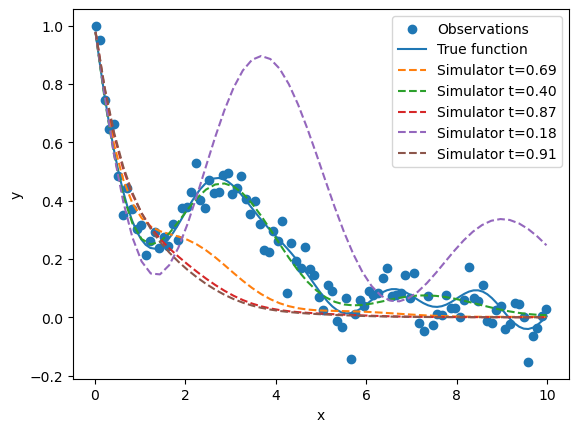

In [4]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xf, yf, label='Observations')
ax.plot(xf, zeta(xf), label='True function')
rng = np.random.default_rng()
ts = rng.permutation(np.unique(tc))[:5]
for t in ts:
    rows = tc==t
    ax.plot(xc[rows], yc[rows], '--', label=f'Simulator t={t:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [5]:
class Model(kgx.KOHModel):
    def k_eta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['eta']
        return gpx.kernels.ProductKernel(
            kernels=[
                gpx.kernels.RBF(
                    active_dims=[0],
                    lengthscale=jnp.array(params['lengthscales']['x_0']),
                    variance=jnp.array(1/params['variances']['precision'])
                ), 
                gpx.kernels.RBF(
                    active_dims=[1],
                    lengthscale=jnp.array(params['lengthscales']['theta_0']),
                )
            ]
        )

    def k_delta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['delta']
        return gpx.kernels.ProductKernel(
            kernels=[
                gpx.kernels.Periodic(
                    active_dims=[0],
                    lengthscale=jnp.array(params['lengthscales']['periodic']),
                    variance=jnp.array(1/params['variances']['precision']),
                    period=jnp.array(params['periods']['periodic'])
                ),
                gpx.kernels.RBF(
                    active_dims=[0],
                    lengthscale=jnp.array(params['lengthscales']['x_0']),
                    # variance defaults to 1.0
                ),
            ]
        )
    
    def k_epsilon_eta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['epsilon_eta']
        return gpx.kernels.White(
                active_dims=[0],
                variance=jnp.array(1/params['variances']['precision'])
            )

In [6]:
# account for the scaling onto [0, 1]
A = (0.3 - tmin)/(tmax - tmin)
B = (0.5 - tmin)/(tmax - tmin)
print(f"A: {A}, B: {B}")
prior_dict: PriorDict = {
    'thetas': {
        'theta_0': ParameterPrior(
            dist.Uniform(low=A, high=B),
            name='theta_0',
        ),
    },
    'eta': {
        'variances': {
                'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=4.0),
                name='eta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                dist.Gamma(concentration=4.0, rate=1.4),
                name='eta_lengthscale_x_0',
            ),
            'theta_0': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=3.5),
                name='eta_lengthscale_theta_0',
            ),
        },
    },
    'delta': {
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=0.1),
                name='delta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                dist.Gamma(concentration=4.0, rate=2.0),
                name='delta_lengthscale_x_0',
            ),
            'periodic': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=1.0),
                name='delta_lengthscale_periodic',
            ),
        },
        'periods': {
            'periodic': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=1.0),
                name='delta_period_periodic',
            ),
        },
    },
    'epsilon': { # This is required despite not appearing in the model
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=12.0, rate=0.025),
                name='epsilon_precision',
            ),
        },
    },
    'epsilon_eta': {
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=10.0, rate=0.001),
                name='epsilon_eta_precision',
            ),
        },
    },
}

model_parameters = ModelParameters(
    prior_dict=prior_dict
)

A: 0.2996808663372773, B: 0.5278731076646374


# MCMC Setup

In [7]:
model = Model(
    model_parameters=model_parameters,
    kohdataset=kohdataset,
)

The jax backend here will jit and grad the nlpd function we provide.

In [8]:
##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=model.get_KOH_neg_log_pos_dens_func(),
    backend="jax",
)
integrator = mici.integrators.LeapfrogIntegrator(system)

In [9]:
prior_leaves, prior_tree = jax.tree.flatten(prior_dict)
prior_means = jax.tree.map(
    lambda x: x.inverse(x.distribution.mean), prior_leaves
)

init_states = np.array(prior_means) # NOT jnp.array
print(f"Initial states: {init_states}")

Initial states: [ 0.69314718  0.69314718  0.69314718  2.99573227  6.1737861   9.21034037
 -0.55961579  1.04982212 -0.69314718  0.        ]


In [10]:
f = model.get_KOH_neg_log_pos_dens_func()
f(init_states)

Array(-361.21679415, dtype=float64)

# Running MCMC algorithm

First, build the tracer function to get the chains for each parameter. We need to know the ordering of the parameter when jax flattens the pytree. This ordering is easiest obtained if we assign names to the parameters priors. We can simply extract the parameter name and index by iterating through the priors_flat list.

In [11]:
tracer_index_dict = {}
for i, prior in enumerate(model_parameters.priors_flat):
    tracer_index_dict[prior.name] = i
# print(tracer_index_dict)

In [12]:
seed = 1234
n_chain = 2
n_process = 1 # only 1 works on MacOS
n_warm_up_iter = 60
n_main_iter = 80
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng, max_tree_depth=5)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    trace = {
        key: state.pos[index] for key, index in tracer_index_dict.items()
    }
    trace['hamiltonian'] = system.h(state)
    return trace

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    [init_states] * n_chain, 
    adapters=adapters, 
    n_process=n_process, 
    trace_funcs=[trace_func],
    monitor_stats=("n_step", "accept_stat", "step_size", "diverging")
)

Sampling stage: Initial fast adaptive [00:05] > Slow adaptive (1/1) [01:26] > Final fast adaptive [00:03] > Main non-adaptive [00:45]

Chain 1/2: 100%|██████████|80/80 [00:22<00:00, 3.49it/s, n_step=8.10, accept_stat=0.912, step_size=0.525, diverging=0.00]

Chain 2/2: 100%|██████████|80/80 [00:22<00:00, 3.51it/s, n_step=8.05, accept_stat=0.917, step_size=0.525, diverging=0.00]

# Analyse MCMC output

In [13]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_periodic,0.982,0.343,0.378,1.563,0.024,0.022,215.0,140.0,1.04
delta_lengthscale_x_0,1.364,0.285,0.908,2.045,0.021,0.025,195.0,115.0,1.00
delta_period_periodic,0.675,0.065,0.570,0.807,0.004,0.009,240.0,105.0,1.03
delta_precision,3.687,0.446,2.856,4.474,0.036,0.037,207.0,116.0,1.01
epsilon_eta_precision,12.220,0.068,12.087,12.328,0.004,0.004,268.0,136.0,1.02
epsilon_precision,5.921,0.138,5.706,6.197,0.007,0.015,353.0,68.0,1.00
eta_lengthscale_theta_0,-1.177,0.042,-1.250,-1.101,0.003,0.002,268.0,117.0,1.00
eta_lengthscale_x_0,0.769,0.034,0.703,0.833,0.003,0.003,170.0,137.0,1.00
eta_precision,-1.335,0.334,-2.007,-0.824,0.025,0.021,200.0,116.0,1.01
hamiltonian,-2116.985,3.460,-2122.263,-2110.267,0.647,0.587,34.0,43.0,1.03


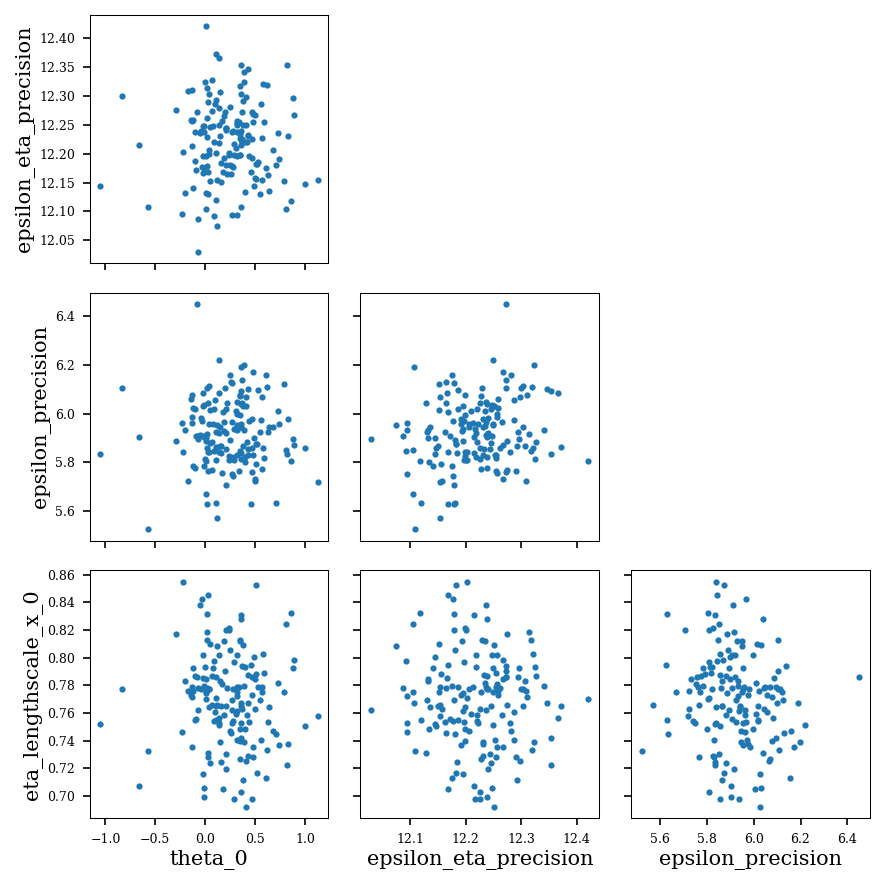

In [14]:
with plt.style.context(plot_style):
    axes = arviz.plot_pair(
        traces,
        var_names=["theta_0", "epsilon_eta_precision", "epsilon_precision", "eta_lengthscale_x_0"],
        figsize=(6, 6)
    )
    axes[0, 0].figure.tight_layout()

# Transform the Chains

In [15]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    index = tracer_index_dict[var]
    traces_transformed[var] = model_parameters.priors_flat[index].forward(np.array(trace))
    if var == 'theta_0':
        trace = traces_transformed[var]
        traces_transformed[var] = list((jnp.array(trace) * (tmax - tmin)) + tmin)

params_transformed_flat = {}
for var, trace in traces_transformed.items():
    params_transformed_flat[var] = np.mean(trace) # This operation is valid across chains when each chain has equal length (I think).
    print(var, ": ", np.mean(trace), '±', np.std(trace))

params_transformed = jax.tree.unflatten(
    prior_tree,
    params_transformed_flat.values()
)

delta_lengthscale_periodic :  2.8298699686177304 ± 0.9861675998904412
delta_lengthscale_x_0 :  4.068642107607346 ± 1.1596989563850222
delta_period_periodic :  1.9689115637730166 ± 0.13016734258551077
delta_precision :  43.740963605696905 ± 18.08036291080474
epsilon_precision :  376.50625877424926 ± 52.95072500167144
epsilon_eta_precision :  203204.58655045007 ± 13757.998216605412
eta_lengthscale_theta_0 :  0.308402358146265 ± 0.012826275510345299
eta_lengthscale_x_0 :  2.159766800775202 ± 0.07300482728510332
eta_precision :  0.2776654563139645 ± 0.08940610764069955
theta_0 :  0.4115418226312674 ± 0.015161661063554294


In [16]:
arviz.summary(traces_transformed)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_periodic,2.830,0.989,1.311,4.522,0.068,0.077,215.0,140.0,1.03
delta_lengthscale_x_0,4.069,1.163,1.713,6.088,0.083,0.104,195.0,115.0,1.00
delta_period_periodic,1.969,0.131,1.693,2.164,0.009,0.018,240.0,105.0,1.03
delta_precision,43.741,18.137,13.274,73.920,1.232,1.413,207.0,116.0,1.01
epsilon_eta_precision,203204.587,13801.195,177603.139,225874.895,855.837,874.558,268.0,136.0,1.02
epsilon_precision,376.506,53.117,278.156,462.735,2.828,6.384,353.0,68.0,1.00
eta_lengthscale_theta_0,0.308,0.013,0.286,0.333,0.001,0.001,268.0,117.0,1.00
eta_lengthscale_x_0,2.160,0.073,2.020,2.299,0.006,0.006,170.0,137.0,1.00
eta_precision,0.278,0.090,0.134,0.439,0.006,0.005,200.0,116.0,1.01
theta_0,0.412,0.015,0.390,0.442,0.001,0.002,169.0,99.0,1.00


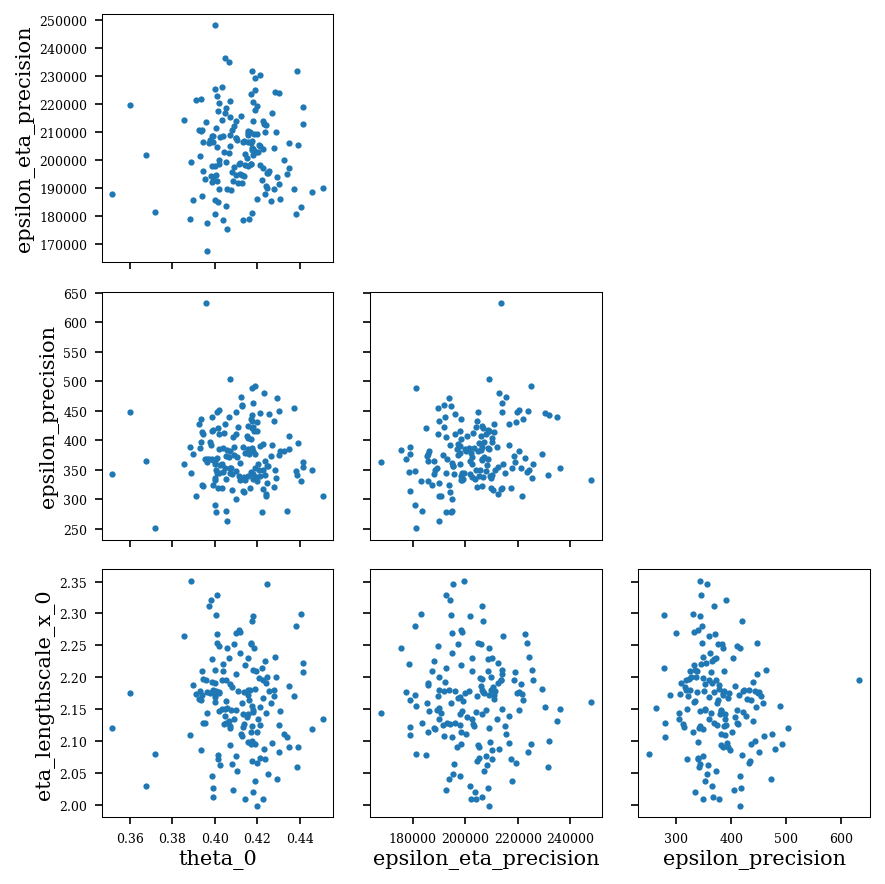

In [17]:
with plt.style.context(plot_style):
    axes = arviz.plot_pair(
        traces_transformed,
        var_names=["theta_0", "epsilon_eta_precision", "epsilon_precision", "eta_lengthscale_x_0"],
        figsize=(6, 6)
    )
    axes[0, 0].figure.tight_layout()

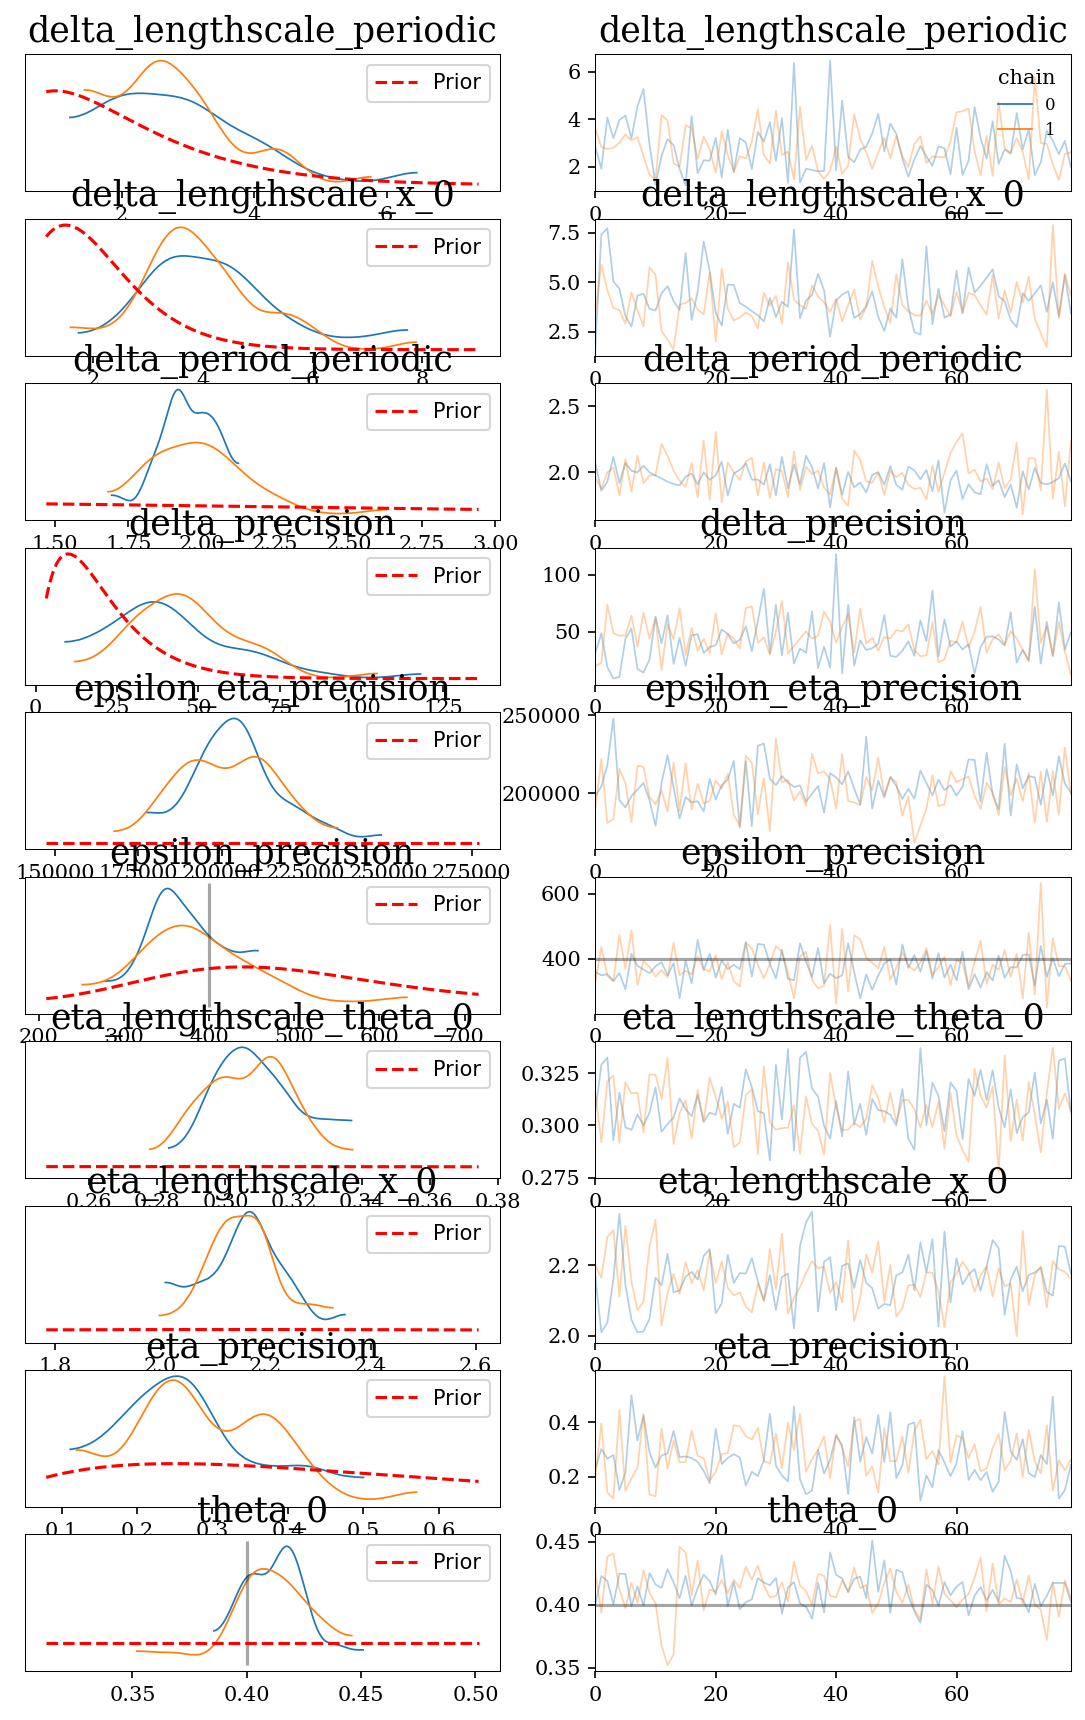

In [18]:
with plt.style.context(plot_style):
    axes = arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
        lines=(
            ('theta_0', {}, 0.4),
            ('epsilon_precision', {}, 1/0.05**2),
        )
    )
for i in range(axes.shape[0]):
    left, right = axes[i, 0].get_xlim()
    left, right = left*0.9, right*1.1
    x = np.linspace(left, right, 1000)
    title = axes[i, 0].get_title()
    prior_dist = model_parameters.priors_flat[tracer_index_dict[title]].distribution
    pdf = jnp.exp(prior_dist.log_prob(x))
    axes[i, 0].plot(x, pdf, color='red', linestyle='--', label='Prior')
    axes[i, 0].legend()
plt.show()
plt.show()

# Analyse posterior fit

## Prediction data

In [19]:
theta = params_transformed_flat['theta_0']*(tmax - tmin) + tmin

xpred = np.linspace(0, 10, 1000)

x_test = np.vstack((xpred, theta*np.ones_like(xpred))).T
dataset = kohdataset.get_dataset(jnp.array(theta).reshape(-1,1))

## Posterior GPs

In [20]:
GP_posterior = model.GP_posterior(params_transformed)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


eta_pred_m = eta_pred.mean
eta_pred_v = eta_pred.variance
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean
zeta_pred_v = zeta_pred.variance
zeta_pred_sd = np.sqrt(zeta_pred_v)

obs_pred_m = obs_pred.mean
obs_pred_v = obs_pred.variance
obs_pred_sd = np.sqrt(obs_pred_v)

x = np.linspace(0, 10, 500)

## Plot GP modelling simulator

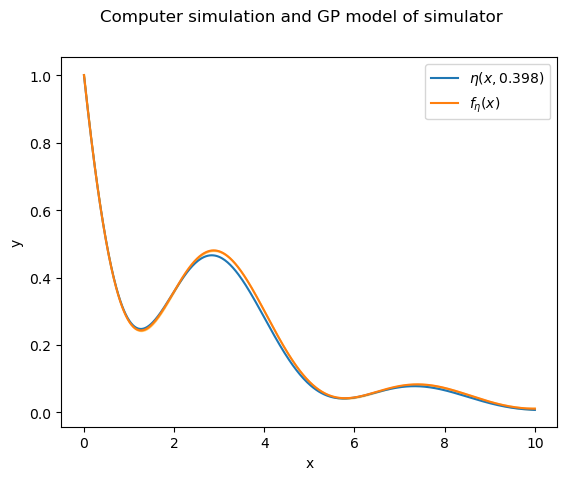

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, eta(x, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

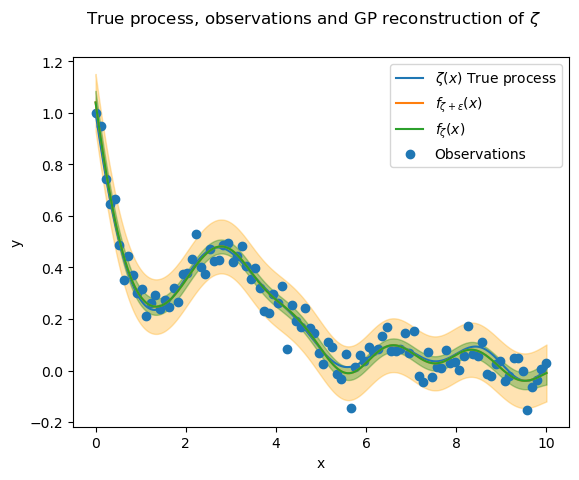

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, zeta(x), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(kohdataset.Xf, kohdataset.z, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [23]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

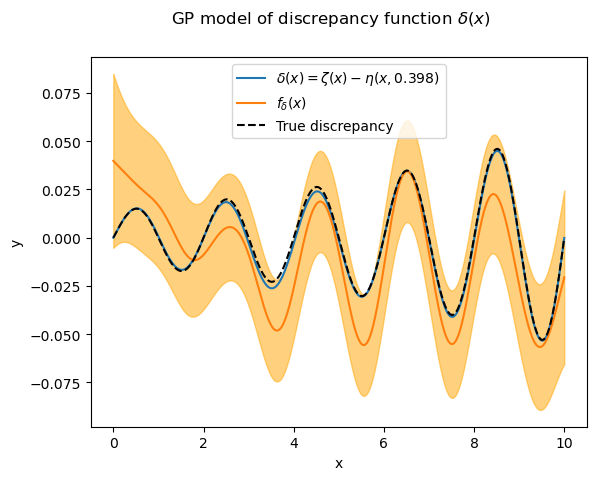

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x) - eta(x, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax.plot(x, discrepancy(x), color='black', linestyle='--', label='True discrepancy')

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()